<a href="https://colab.research.google.com/github/kb21032001/Bird_audio_classifier_Resnet/blob/main/Bird_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import random
import pandas as pd
from IPython.display import Audio
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import normalize
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import models
import torchaudio
import torchaudio.transforms as a_T
import torchvision.transforms as v_T
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.restoration import denoise_wavelet
import pandas as pd
import warnings
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
random.seed(1)
torch.random.manual_seed(1)
torch.manual_seed(1)

In [21]:
dataset_path = "/content/drive/MyDrive/birdclef-2022/train_audio"
class Species:
    def __init__(self, name, recordings):
        self.name = name
        self.recordings = recordings
        self.len = len(self.recordings)

    def set_label(self, label):
        #Label of a specie based on the number of recrdings the dataset has
        self.label = label

    def compute_len(self):
        self.len = len(self.recordings)

    def __repr__(self):
        return '{' + 'Name:' + self.name + ', ' + 'No. Recs:' + str(self.len) + ', ' + 'Label:' + str(self.label) + '}'

def get_spectrogram(wave: torch.Tensor, sample_rate=16000, n_fft=1024, hop_length=512, n_mels=40):
  mel_spectrogram = a_T.MelSpectrogram(sample_rate, n_fft, hop_length, n_mels)
  melspec = mel_spectrogram(wave)
  # code below is for resizing to 224x224 for resnet
  desired_size = (224, 224)
  melspec = F.interpolate(melspec.unsqueeze(0).unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
  melspec = melspec.squeeze()
  return melspec

def plot_wave_and_spectrogram(wave: torch.Tensor, melspec: torch.Tensor, label="BirdCall"):
  fig, (ax1, ax2) = plt.subplots(2,1)
  fig.suptitle(label)
  ax1.plot(wave)
  ax2.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

def preprocess_one_audio(path, target_duration=2, target_sr=16000):
    #Load, mono, downsample, take random 30 sec crop
    y, sr = torchaudio.load(path)
    mono = y
    if(len(y) == 2):
        mono = torch.unsqueeze(y[0], 0)
    downsample = a_T.Resample(sr, target_sr)(mono)
    duration = 30
    crop = v_T.RandomCrop((1, duration*target_sr), pad_if_needed=True)(downsample)
    crop = downsample

    #PCEN-SNR Technique to get most imp 1 sec clip
    def get_peaks(y, sr, n_peaks=12, kernel_size=15, zero_dist=50, FMIN=500, FMAX=12500):
        # Spec
        melspec = librosa.feature.melspectrogram(y=y, sr=sr,
            fmin=FMIN, fmax=FMAX, n_mels=64)
        pcen = librosa.core.pcen(melspec, sr=sr,
            gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
        # SNR
        pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
        avg_pcen_snr = np.median(pcen_snr)
        if avg_pcen_snr == 0:
            if np.mean(pcen_snr) == 0:
                avg_pcen_snr = 1
            else:
                avg_pcen_snr = np.mean(pcen_snr)
        pcen_snr = librosa.power_to_db(pcen_snr / avg_pcen_snr)
        # SMoothed SNR
        median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
        # And go through, picking some peaks
        times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
        peak_locs = []
        for i in range(n_peaks):
            t_peak = np.argmax(median_pcen_snr)
            peak_locs.append(times[t_peak])
            median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one
        return peak_locs

    peaks = get_peaks(crop[0].numpy(), target_sr, n_peaks=20)
    start_time = min(len(crop[0])/target_sr - target_duration, max(float(peaks[0])-target_duration/2, target_duration/2))
    start_frame = int(start_time * target_sr)
    stop_frame = start_frame + target_duration * target_sr
    chopped = crop[0][start_frame: stop_frame]
    x_denoise = torch.tensor(denoise_wavelet(chopped.numpy(), method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True'))
    normalize_amp = normalize(x_denoise, dim=0)
    return normalize_amp, target_sr

In [22]:
csv = "/content/drive/MyDrive/birdclef-2022/train_metadata.csv"
train_df = pd.read_csv(csv)
train_df = train_df.query("rating>=5")
known = ["houspa", "rinphe", "houfin", "moudov", "rocpig"]
negative = ["mallar3", "brnowl", "comsan"]
birds_count = {}
for bird_species, count in zip(train_df.primary_label.unique(), train_df.groupby("primary_label")["primary_label"].count().values):
    birds_count[bird_species] = count
for bird in birds_count:
  if bird in known:
    print(bird, birds_count[bird])

houfin 72
houspa 89
moudov 16
rinphe 63
rocpig 19


In [23]:
birds = {label: Species(label, []) for label in known}
birds["nobird"] = Species("nobird", [])
for row in train_df.itertuples(index=True, name='Pandas'):
    primary_label = getattr(row, "primary_label")
    filename = getattr(row, "filename")
    full_path = os.path.join(dataset_path, filename)

    # Add the filename to the corresponding Bird instance
    if primary_label in known:
        birds[primary_label].recordings.append(full_path)

    if primary_label in negative:
        birds['nobird'].recordings.append(full_path)

In [24]:
np.random.shuffle(birds['nobird'].recordings)

In [25]:
for b in birds:
  birds[b].compute_len()
species = list(birds.values())
species.sort(key=lambda s: s.len, reverse=True)
for i, specie in enumerate(species):
    specie.set_label(i)

In [26]:
species

[{Name:nobird, No. Recs:364, Label:0},
 {Name:houspa, No. Recs:89, Label:1},
 {Name:houfin, No. Recs:72, Label:2},
 {Name:rinphe, No. Recs:63, Label:3},
 {Name:rocpig, No. Recs:19, Label:4},
 {Name:moudov, No. Recs:16, Label:5}]

/content/drive/MyDrive/birdclef-2022/train_audio/houspa/XC124181.ogg


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


tensor([[1.5148e-05, 4.6335e-07, 1.2159e-08,  ..., 1.6925e-09, 1.2083e-07,
         4.0354e-06],
        [1.5248e-05, 4.3243e-07, 1.7378e-08,  ..., 6.4729e-09, 1.0380e-07,
         4.1815e-06],
        [1.5407e-05, 3.8296e-07, 2.5727e-08,  ..., 1.4122e-08, 7.6534e-08,
         4.4152e-06],
        ...,
        [1.9493e-08, 5.8378e-10, 2.5440e-17,  ..., 2.3482e-07, 5.0176e-07,
         4.9791e-07],
        [1.9639e-08, 5.8810e-10, 1.3098e-17,  ..., 1.3803e-07, 3.2781e-07,
         1.1297e-06],
        [1.9730e-08, 5.9080e-10, 5.3846e-18,  ..., 7.7531e-08, 2.1910e-07,
         1.5245e-06]])
torch.Size([224, 224])


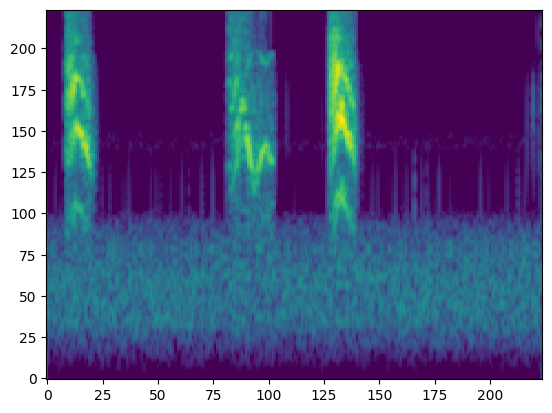

In [27]:
r = '/content/drive/MyDrive/birdclef-2022/train_audio/houspa/XC124181.ogg'
print(r)
IPython.display.display(IPython.display.Audio(r, rate=32000))
y, sr = preprocess_one_audio(r)
IPython.display.display(IPython.display.Audio(y, rate=sr))
melspec = get_spectrogram(y)
print(melspec)
print(melspec.shape)
fig, (ax1) = plt.subplots(1,1)
ax1.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

/content/drive/MyDrive/birdclef-2022/train_audio/houspa/XC139186.ogg


tensor([[6.2167e-05, 2.0359e-06, 1.2476e-09,  ..., 1.0481e-09, 1.4916e-07,
         4.9937e-06],
        [6.2229e-05, 2.0440e-06, 5.2918e-09,  ..., 9.1155e-10, 1.3849e-07,
         5.0858e-06],
        [6.2327e-05, 2.0571e-06, 1.1762e-08,  ..., 6.9311e-10, 1.2142e-07,
         5.2333e-06],
        ...,
        [2.1341e-04, 1.2609e-04, 1.1301e-04,  ..., 4.4988e-15, 3.9638e-12,
         1.2645e-10],
        [1.9745e-04, 1.4010e-04, 1.6044e-04,  ..., 3.2645e-15, 3.9839e-12,
         1.2718e-10],
        [1.8748e-04, 1.4885e-04, 1.9008e-04,  ..., 2.4930e-15, 3.9964e-12,
         1.2764e-10]])
torch.Size([224, 224])


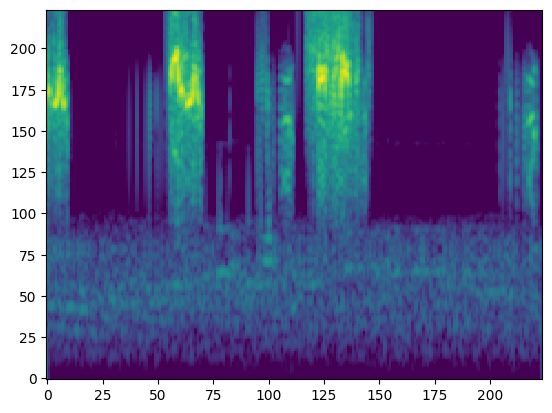

In [28]:
r = '/content/drive/MyDrive/birdclef-2022/train_audio/houspa/XC139186.ogg'
print(r)
IPython.display.display(IPython.display.Audio(r, rate=32000))
y, sr = preprocess_one_audio(r)
IPython.display.display(IPython.display.Audio(y, rate=sr))
melspec = get_spectrogram(y)
print(melspec)
print(melspec.shape)
fig, (ax1) = plt.subplots(1,1)
ax1.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

In [29]:
#Ensures equal amount of data per species in train, val, test set
def get_XY(start, end, num_of_species, species):
    #Array of tuples(X: melspec, Y: label of the bird, Z: Path of the rec for verification)
    X, Y, Z = [], [], []
    for i, specie in enumerate(species[:num_of_species]):
        recs = specie.recordings[start:end]
        for rec in recs:
            melspec = get_spectrogram(preprocess_one_audio(rec)[0])
            X.append(melspec)
            Y.append(i)
            # Y.append([i,int(rec.split('/')[-1].split('.')[0][2:])])
            Z.append(rec)
    return [torch.stack(X), torch.tensor(Y), Z]

def get_labelled_data(species, num_of_species=3, num_of_recs_per_species=72, split_train=0.8, split_val=0.1, split_test=0.1):
    data_train = get_XY(0, int(num_of_recs_per_species*split_train), num_of_species, species)
    data_val = get_XY(int(num_of_recs_per_species*split_train), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val), num_of_species, species)
    data_test = get_XY(int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val + num_of_recs_per_species*split_test), num_of_species, species)
    return data_train, data_val, data_test

def save_labelled_data(train, val, test):
    X_train, Y_train = train[0], train[1]
    X_val, Y_val = val[0], val[1]
    X_test, Y_test = test[0], test[1]
    torch.save(X_train.clone().detach(), 'classifier_X_train.pt')
    torch.save(Y_train.clone().detach(), 'classifier_Y_train.pt')
    torch.save(X_val.clone().detach(), 'classifier_X_val.pt')
    torch.save(Y_val.clone().detach(), 'classifier_Y_val.pt')
    torch.save(X_test.clone().detach(), 'classifier_X_test.pt')
    torch.save(Y_test.clone().detach(), 'classifier_Y_test.pt')
    X_train, Y_train, X_val, Y_val, X_test, Y_test = None, None, None, None, None, None
    del X_train
    del Y_train
    del X_val
    del Y_val
    del X_test
    del Y_test

def retrieve_labelled_data():
    X_train, Y_train = torch.load('classifier_X_train.pt'), torch.load('classifier_Y_train.pt')
    X_val, Y_val = torch.load('classifier_X_val.pt'), torch.load('classifier_Y_val.pt')
    X_test, Y_test = torch.load('classifier_X_test.pt'), torch.load('classifier_Y_test.pt')
    return [X_train, Y_train], [X_val, Y_val], [X_test, Y_test]

def get_data_samplers(train, val, random_seed=1):
    #shuffle training, val data
    def shuffle_indices(indices):
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler
    train_sampler = shuffle_indices(list(range(len(train[0]))))
    val_sampler = shuffle_indices(list(range(len(val[0]))))
    return train_sampler, val_sampler

In [30]:
###########Save tensors only if config better than num_of_species=2, num_of_recs_per_species=100###########
train, val, test = get_labelled_data(species)
save_labelled_data(train, val, test)
train1, val1, test1 = retrieve_labelled_data()
train_sampler, val_sampler= get_data_samplers(train1, val1)

In [31]:
class ClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(ClassifierDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.len = X.size(0)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

classifier_train_dataset = ClassifierDataset(train1[0], train1[1])
classifier_val_dataset = ClassifierDataset(val1[0], val1[1])
classifier_test_dataset = ClassifierDataset(test1[0], test1[1])

In [32]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(classifier_train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(classifier_train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(classifier_test_dataset, batch_size=batch_size)

In [17]:
#Defining the Classifier module
class Classifier(nn.Module):

    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.lin_size = 64*32*200
        self.blocks = nn.ModuleList([
            nn.Sequential(
                # 1-2
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=(2,2)),
            ),
            nn.Sequential(
                # 3-4
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=(2,2)),
                nn.Dropout(0.5),
            ),
        ])
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.lin_size, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        #conv block
        for b in self.blocks:
            x = b(x)
        #lin blocks
        x = x.view(-1, self.lin_size)
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [33]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 3)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.8MB/s]

Number of features from pre-trained model 512


In [18]:
model = Classifier(n_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

Epoch 1, Training Loss: 0.9837
Epoch 2, Training Loss: 0.8611
Epoch 3, Training Loss: 0.7992
Epoch 4, Training Loss: 0.7343
Epoch 5, Training Loss: 0.6630
Epoch 6, Training Loss: 0.6334
Epoch 7, Training Loss: 0.5787
Epoch 8, Training Loss: 0.5870
Epoch 9, Training Loss: 0.5087
Epoch 10, Training Loss: 0.5082


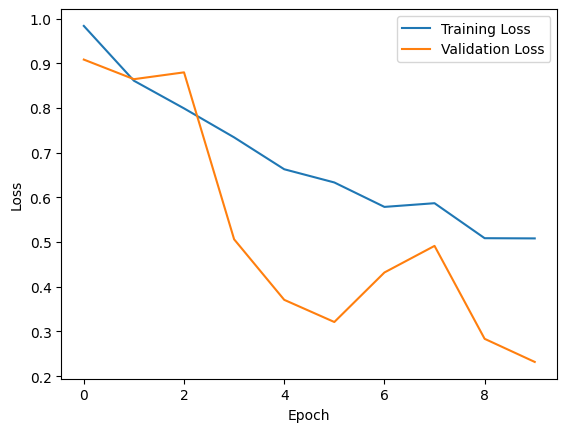

In [37]:
# train the network with low epochs
n_epoch = 10
train_losses = []
val_losses = []
for epoch in range(n_epoch):
    training_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        optimizer.zero_grad()
        inputs = torch.cat([inputs] * 3, dim=1)
        # print (inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, raw_labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    average_train_loss = training_loss / len(train_loader)
    train_losses.append(average_train_loss)

    validation_loss = 0.0
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(val_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        inputs = torch.cat([inputs] * 3, dim=1)
        outputs = model(inputs)
        loss = criterion(outputs, raw_labels)
        validation_loss += loss.item()
    average_val_loss = validation_loss / len(val_loader)
    val_losses.append(average_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {average_train_loss:.4f}")
    torch.save(model, "firstModel.pth")

plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
#test accuracy
accuracy = 0.0
total = 0.0
loaded_model = torch.load("firstModel.pth")
loaded_model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, raw_labels = data[0].unsqueeze(dim=1), data[1]
        inputs = torch.cat([inputs] * 3, dim=1)
        outputs = F.softmax(loaded_model(inputs), dim=1)
        print(outputs)
        _, predicted = torch.max(outputs, 1)
        total += raw_labels.size(0)
        accuracy += (predicted == raw_labels).sum().item()

accuracy = (100 * accuracy/total)
print(accuracy)

tensor([[0.5820, 0.2460, 0.1720],
        [0.5827, 0.2446, 0.1727],
        [0.8815, 0.0756, 0.0429],
        [0.7039, 0.1489, 0.1472],
        [0.8017, 0.0596, 0.1387],
        [0.8129, 0.0855, 0.1016],
        [0.7050, 0.0811, 0.2139],
        [0.7514, 0.1201, 0.1285],
        [0.0998, 0.5906, 0.3096],
        [0.3764, 0.4569, 0.1667]])
tensor([[0.1725, 0.6082, 0.2193],
        [0.2301, 0.5769, 0.1930],
        [0.1891, 0.6189, 0.1920],
        [0.1581, 0.5673, 0.2746],
        [0.4539, 0.2666, 0.2795],
        [0.4825, 0.2202, 0.2973],
        [0.5101, 0.3247, 0.1652],
        [0.4049, 0.1465, 0.4486],
        [0.0786, 0.2818, 0.6395],
        [0.0922, 0.4427, 0.4651]])
tensor([[0.0363, 0.0604, 0.9033],
        [0.0205, 0.2074, 0.7720],
        [0.0220, 0.4843, 0.4937],
        [0.0513, 0.0747, 0.8739]])
87.5
